In [1]:
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from tqdm.notebook import tqdm  # Better progress bars in Jupyter
import matplotlib.pyplot as plt

In [2]:
# Change these if needed
base_dir = r'F:\Project\GPU\CV\brain2'
filtered_dir = r'F:\Project\GPU\CV\brain2_filtered'

# Create filtered directory if it doesn't exist
os.makedirs(filtered_dir, exist_ok=True)

In [4]:
def apply_median_filter_and_save(input_root, output_root, kernel_size=3):
    """
    Applies median blur to all images and saves them while preserving folder structure.
    """
    for split in ['Training', 'Testing']:
        input_dir = os.path.join(input_root, split)
        output_dir = os.path.join(output_root, split)
        os.makedirs(output_dir, exist_ok=True)
        
        print(f"Processing {split}...")
        for class_name in os.listdir(input_dir):
            class_input = os.path.join(input_dir, class_name)
            class_output = os.path.join(output_dir, class_name)
            os.makedirs(class_output, exist_ok=True)
            
            for file in os.listdir(class_input):
                if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    img_path = os.path.join(class_input, file)
                    img = cv2.imread(img_path)
                    if img is not None:
                        filtered = cv2.medianBlur(img, kernel_size)
                        cv2.imwrite(os.path.join(class_output, file), filtered)

# Run the filtering
apply_median_filter_and_save(base_dir, filtered_dir, kernel_size=3)
print(f"\nFiltered images saved to: {filtered_dir}")

Processing Training...
Processing Testing...

Filtered images saved to: F:\Project\GPU\CV\brain2_filtered


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))

Using device: cuda
NVIDIA GeForce RTX 3050 Laptop GPU


In [4]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # EfficientNet expects 224+; 256 is safe
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(os.path.join(filtered_dir, 'Training'), transform=transform)
test_dataset = datasets.ImageFolder(os.path.join(filtered_dir, 'Testing'), transform=transform)

print(f"Classes: {train_dataset.classes}")
print(f"Training samples: {len(train_dataset)}")
print(f"Testing samples: {len(test_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Training samples: 5712
Testing samples: 1311


In [5]:
from torchvision import models
import torch.nn as nn

# EfficientNet-B1: fast training, excellent accuracy (~98–99% on this dataset)
model = models.efficientnet_b1(weights='DEFAULT')

# Replace the final classifier layer for 4 classes
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 4)

model = model.to(device)
print("EfficientNet-B1 loaded and moved to GPU")

Downloading: "https://download.pytorch.org/models/efficientnet_b1-c27df63c.pth" to C:\Users\adity/.cache\torch\hub\checkpoints\efficientnet_b1-c27df63c.pth


100%|██████████| 30.1M/30.1M [01:01<00:00, 517kB/s]


EfficientNet-B1 loaded and moved to GPU


In [6]:
from torch.cuda.amp import autocast, GradScaler
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Mixed precision for faster training and lower memory usage
scaler = GradScaler()

print("Optimizer and mixed precision ready")

Optimizer and mixed precision ready


C:\Users\adity\AppData\Local\Temp\ipykernel_11072\3118861435.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [7]:
num_epochs = 15  # Usually enough to reach 98%+

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    
    for images, labels in tqdm(train_loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        # Mixed precision forward and backward
        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    print(f"Train Loss: {epoch_loss:.4f} | Train Accuracy: {epoch_acc:.2f}%")


Epoch 1/15


Training:   0%|          | 0/179 [00:00<?, ?it/s]

C:\Users\adity\AppData\Local\Temp\ipykernel_11072\3630291015.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 0.5332 | Train Accuracy: 83.93%

Epoch 2/15


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.1493 | Train Accuracy: 95.06%

Epoch 3/15


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.0832 | Train Accuracy: 97.25%

Epoch 4/15


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.0495 | Train Accuracy: 98.58%

Epoch 5/15


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.0280 | Train Accuracy: 99.12%

Epoch 6/15


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.0297 | Train Accuracy: 99.11%

Epoch 7/15


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.0124 | Train Accuracy: 99.75%

Epoch 8/15


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.0135 | Train Accuracy: 99.60%

Epoch 9/15


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.0115 | Train Accuracy: 99.72%

Epoch 10/15


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.0094 | Train Accuracy: 99.72%

Epoch 11/15


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.0084 | Train Accuracy: 99.75%

Epoch 12/15


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.0047 | Train Accuracy: 99.93%

Epoch 13/15


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.0050 | Train Accuracy: 99.88%

Epoch 14/15


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.0129 | Train Accuracy: 99.61%

Epoch 15/15


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.0072 | Train Accuracy: 99.81%


In [8]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Evaluating Test Set"):
        images, labels = images.to(device), labels.to(device)
        with autocast():
            outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

test_accuracy = 100. * correct / total
print(f"\nFinal Test Accuracy: {test_accuracy:.2f}%")

Evaluating Test Set:   0%|          | 0/41 [00:00<?, ?it/s]

C:\Users\adity\AppData\Local\Temp\ipykernel_11072\748190674.py:8: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():



Final Test Accuracy: 99.39%


In [9]:
save_path = r'F:\Project\GPU\CV\brain2_efficientnet_b1_trained.pth'
torch.save(model.state_dict(), save_path)
print(f"Model saved successfully to: {save_path}")

Model saved successfully to: F:\Project\GPU\CV\brain2_efficientnet_b1_trained.pth


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import DataLoader
import random
from torchvision import transforms
from PIL import Image
import torch

In [11]:
model.eval()
all_preds = []
all_labels = []
all_probs = []  # Optional: for confidence

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Getting Predictions"):
        images = images.to(device)
        labels = labels.cpu().numpy()
        
        with torch.cuda.amp.autocast():
            outputs = model(images)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels)
        all_probs.extend(probabilities.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

print("Predictions collected!")

Getting Predictions:   0%|          | 0/41 [00:00<?, ?it/s]

C:\Users\adity\AppData\Local\Temp\ipykernel_11072\678124507.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Predictions collected!


In [12]:
class_names = train_dataset.classes  # ['glioma', 'meningioma', 'notumor', 'pituitary']

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

print("Confusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

Confusion Matrix:
[[293   6   0   1]
 [  0 306   0   0]
 [  0   0 405   0]
 [  0   1   0 299]]

Classification Report:
              precision    recall  f1-score   support

      glioma       1.00      0.98      0.99       300
  meningioma       0.98      1.00      0.99       306
     notumor       1.00      1.00      1.00       405
   pituitary       1.00      1.00      1.00       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



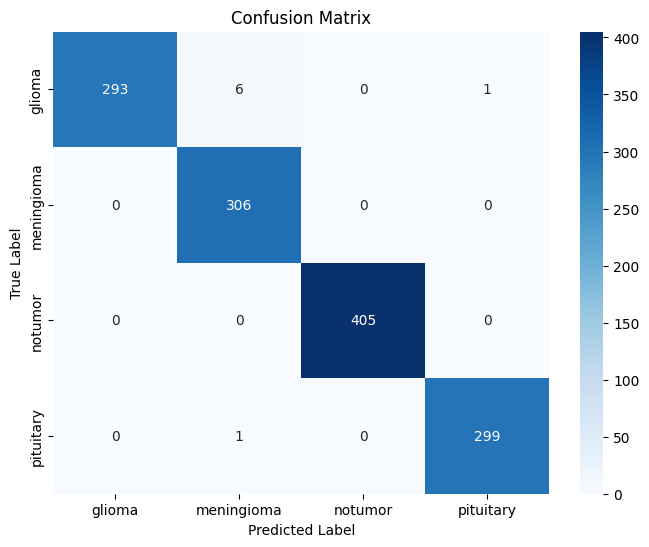

In [13]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

C:\Users\adity\AppData\Local\Temp\ipykernel_11072\717373081.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


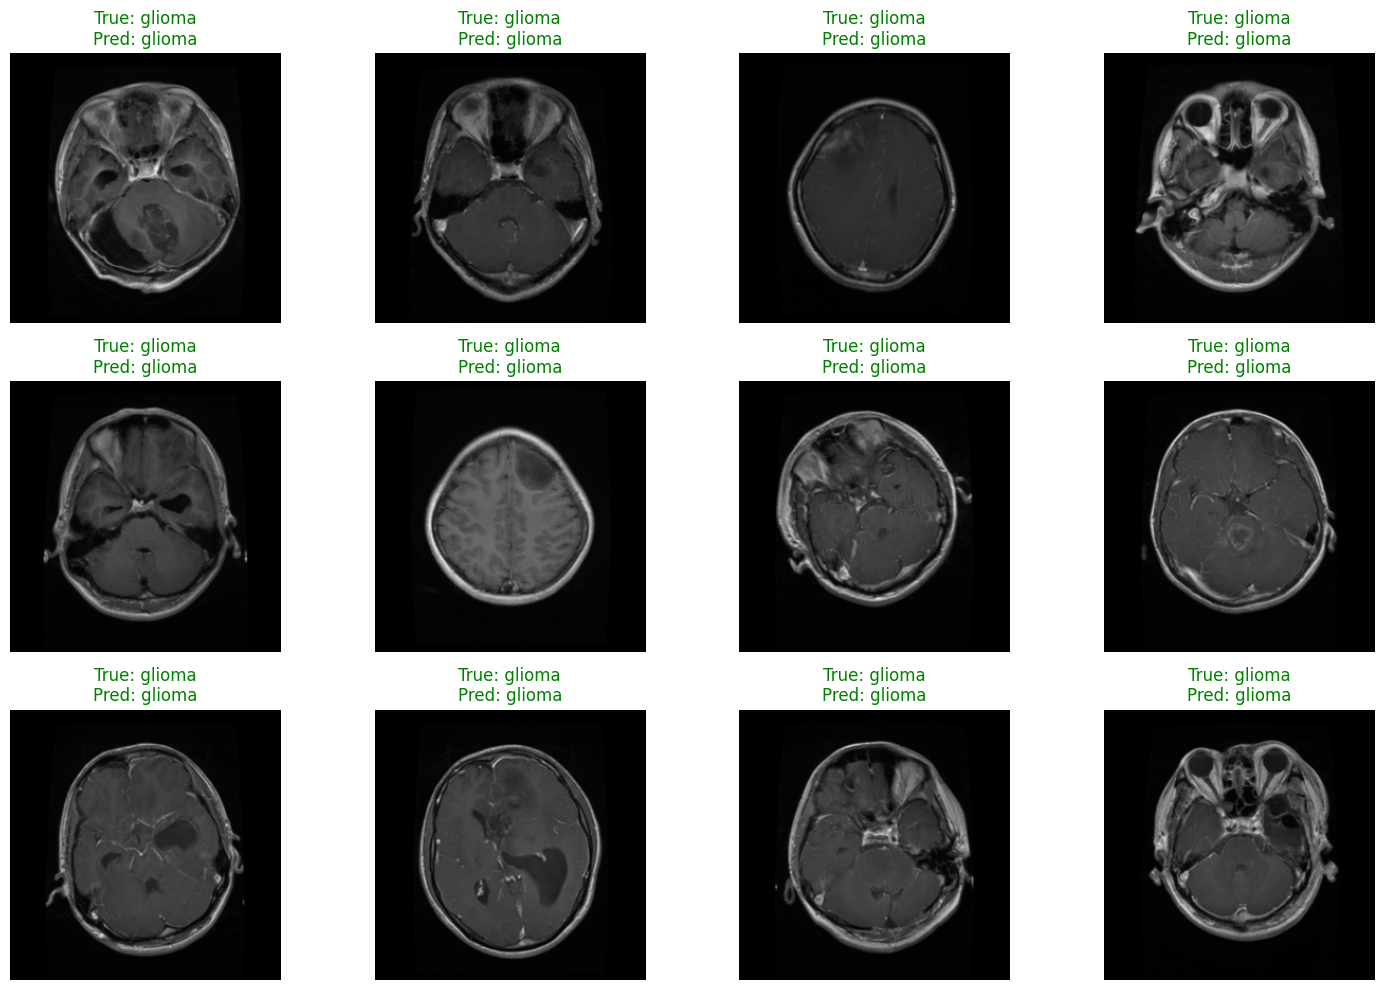

In [14]:
# Inverse transform to denormalize for display
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

def imshow(img, title):
    img = inv_normalize(img)
    img = img.clamp(0, 1)
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')

# Get a batch for visualization
dataiter = iter(test_loader)
images, labels = next(dataiter)
images = images.to(device)
labels = labels.numpy()

with torch.no_grad():
    with torch.cuda.amp.autocast():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predicted = predicted.cpu().numpy()

# Plot 12 random samples
fig = plt.figure(figsize=(15, 10))
for idx in range(12):
    ax = fig.add_subplot(3, 4, idx+1)
    imshow(images[idx], 
           f"True: {class_names[labels[idx]]}\nPred: {class_names[predicted[idx]]}")
    ax.set_title(f"True: {class_names[labels[idx]]}\nPred: {class_names[predicted[idx]]}", 
                 color=("green" if predicted[idx] == labels[idx] else "red"))

plt.tight_layout()
plt.show()

C:\Users\adity\AppData\Local\Temp\ipykernel_11072\3453145359.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_names, y=per_class_acc, palette='viridis')


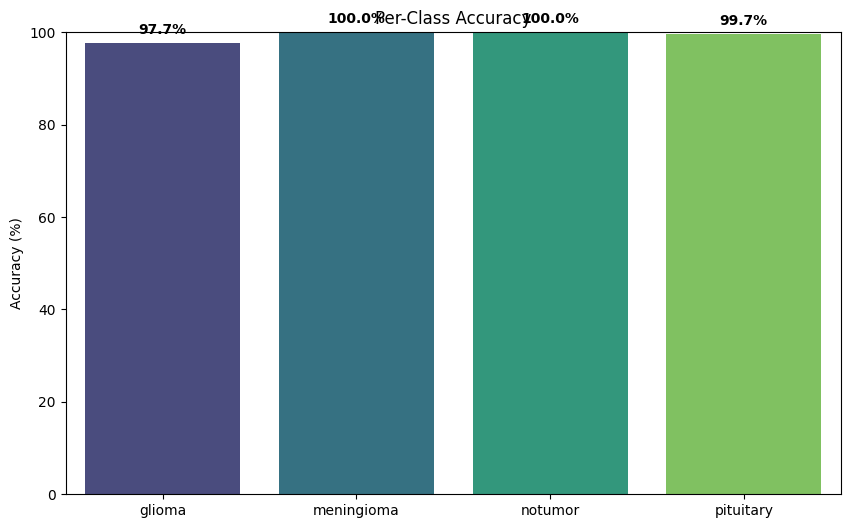

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score

class_names = train_dataset.classes
per_class_acc = []

for i, cls in enumerate(class_names):
    cls_mask = (all_labels == i)
    acc = accuracy_score(all_labels[cls_mask], all_preds[cls_mask])
    per_class_acc.append(acc * 100)

plt.figure(figsize=(10, 6))
sns.barplot(x=class_names, y=per_class_acc, palette='viridis')
plt.title('Per-Class Accuracy')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)
for i, v in enumerate(per_class_acc):
    plt.text(i, v + 2, f'{v:.1f}%', ha='center', fontweight='bold')
plt.show()

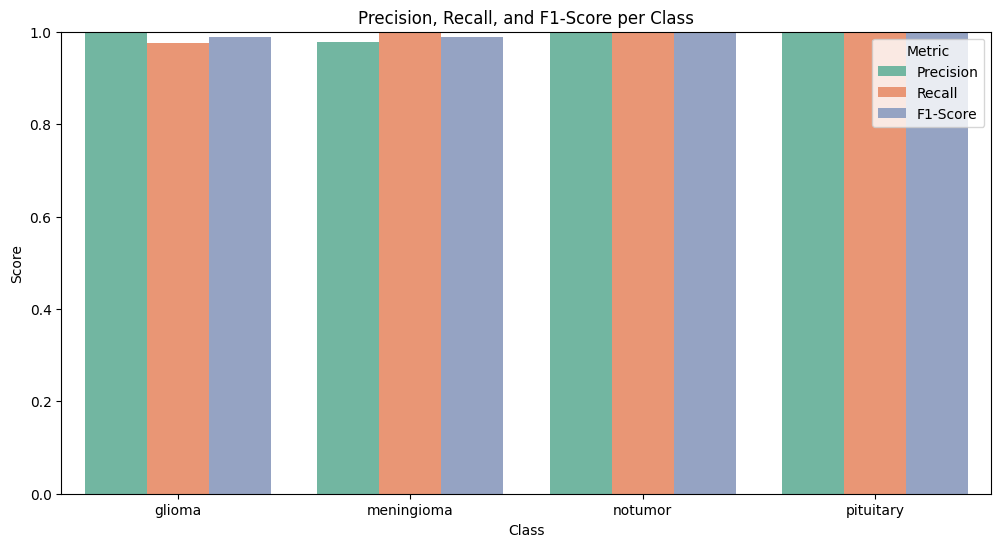

In [17]:
from sklearn.metrics import precision_recall_fscore_support
import pandas as pd
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average=None)

metrics_df = pd.DataFrame({
    'Class': class_names,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
})

metrics_df = metrics_df.melt(id_vars='Class', var_name='Metric', value_name='Score')

plt.figure(figsize=(12, 6))
sns.barplot(data=metrics_df, x='Class', y='Score', hue='Metric', palette='Set2')
plt.title('Precision, Recall, and F1-Score per Class')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.legend(title='Metric')
plt.show()

t-SNE Visualization of Feature Embeddings (Advanced: See How Well Classes Are Separated)

Extracting Features:   0%|          | 0/41 [00:00<?, ?it/s]

C:\Users\adity\AppData\Local\Temp\ipykernel_11072\1847582558.py:31: UserWarning: Mismatched number of handles and labels: len(handles) = 3 len(labels) = 4
  plt.legend(handles=scatter.legend_elements()[0], labels=class_names, title="Classes", loc='best')


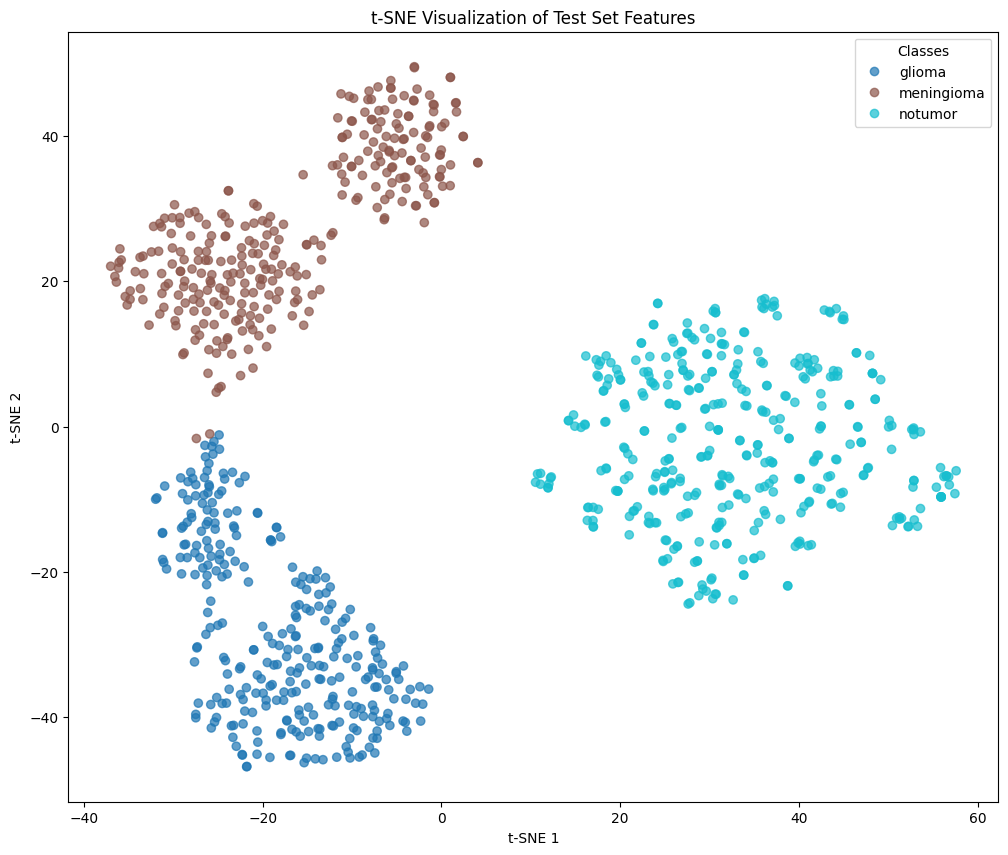

In [19]:
from sklearn.manifold import TSNE
import torch

# Extract features from the second-last layer
model.eval()
features = []
labels_list = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Extracting Features"):
        images = images.to(device)
        # Get features before classifier
        feat = model.features(images)  # For EfficientNet
        feat = model.avgpool(feat)
        feat = torch.flatten(feat, 1)
        features.append(feat.cpu().numpy())
        labels_list.append(labels.numpy())

features = np.concatenate(features)
labels_list = np.concatenate(labels_list)

# t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(features[:1000])  # Limit to 1000 for speed

plt.figure(figsize=(12, 10))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels_list[:1000], cmap='tab10', alpha=0.7)
plt.title('t-SNE Visualization of Test Set Features')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend(handles=scatter.legend_elements()[0], labels=class_names, title="Classes", loc='best')
plt.show()